In [1]:
import os
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
# from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input


In [2]:
# Chargement du script d'importation et formattage des images
%run ./data-importation-and-formatting-v2.py

In [3]:
# Chargement du script de séparation des données
%run ./train_val_test_split.py

In [4]:
data_folder = "../data"
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
img_folder = "images"

lst_dirs_condition = [os.path.join(data_folder, cond, "images") for cond in conditions]

list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Lung Opacity", "Covid", "Normal"],
                                 "img_dir" : lst_dirs_condition})


## Importation et préparation des données

In [5]:
print("IMG_SIZE = ", IMG_SIZE)  # Peut être changée dans le code data-importation-and-formatting-v2

IMG_SIZE =  64


In [6]:
## Importation des images
SAMPLE_SIZE = 2500
sample_size_viral_pneum = np.min([1345, SAMPLE_SIZE])
sample_size_lung_opa = SAMPLE_SIZE - sample_size_viral_pneum
masked_img_df = load_masked_img_multiple_cond_in_df(selected_conditions=conditions, sample_sizes=[sample_size_viral_pneum, sample_size_lung_opa, SAMPLE_SIZE, SAMPLE_SIZE])


In [7]:
masked_img_df.replace({'Viral Pneumonia' : 'Pulmonary infection',
                       'Lung_Opacity' : 'Pulmonary infection'}, inplace=True)

In [8]:
masked_img_df.label.value_counts()

Pulmonary infection    2500
COVID                  2500
Normal                 2500
Name: label, dtype: int64

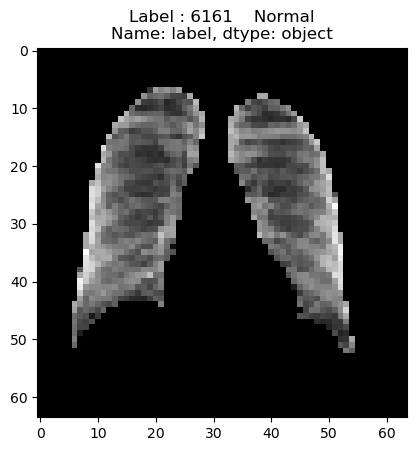

In [9]:
ind = random.sample(range(0,masked_img_df.shape[0]),1)
plt.imshow(np.array(masked_img_df.drop(columns='label').iloc[ind,:]).reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.title(f"Label : {masked_img_df.label[ind]}");

## Séparation en échantillons d'apprentissage, de validation et de test

In [10]:
X = masked_img_df.drop(columns='label')/IMG_SIZE
y = masked_img_df.label

# Encodage de la variable cible en numérique
labenc = LabelEncoder()
y = labenc.fit_transform(y)
print(labenc.classes_)

# Séparation des échantillons
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, 
                                                                      y,
                                                                      test_val_sizes=(0.2, 0.2), random_state=42)

['COVID' 'Normal' 'Pulmonary infection']


In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [12]:
print(X_train.shape[0],X_train.shape[0]/7500)
print(X_val.shape[0], X_val.shape[0]/7500)
print(X_test.shape[0], X_test.shape[0]/7500)


4800 0.64
1200 0.16
1500 0.2


## Modélisation

### Data augmentation

In [13]:
BATCH_SIZE = 64 


train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

val_datagen = ImageDataGenerator()

## Reshaping des images pour correspondre au format couleur pour l'intégration dans VGG
X_train_3 = np.repeat(np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE,1),3,-1)
X_val_3 = np.repeat(np.array(X_val).reshape(-1, IMG_SIZE, IMG_SIZE,1),3,-1)

train_dataset = train_datagen.flow(X_train_3,
                                   y_train,
                        batch_size = BATCH_SIZE)


val_dataset = val_datagen.flow(X_val_3, y_val, batch_size = BATCH_SIZE)

### Construction du modèle

In [14]:
pre_trained_model = VGG16(weights = 'imagenet', include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3))
for layer in pre_trained_model.layers:
    layer.trainable = False
for layer in pre_trained_model.layers[-4:]:
    layer.trainable = True

In [15]:
model = Sequential()

model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
# model.add(Dense(units = 512, activation='relu'))
# model.add(Dropout(rate=0.3))
# model.add(Dense(units = 256, activation='relu'))
# model.add(Dropout(rate=0.2))
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 64, activation = 'relu'))
# model.add(Dropout(rate=0.15))
# model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax')) #3

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) #SparseCategoricalCrossentropy

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [18]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 5,
                               mode = 'min')

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                        factor = 0.1,
                                        patience = 3,
                                        min_delta = 0.01,
                                        cooldown = 4,
                                        verbose = 1)

callbacks_list = [early_stopping,reduce_learning_rate]

In [19]:
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
            validation_data = val_dataset, # use augmented images for test  
            validation_steps = X_val.shape[0]//BATCH_SIZE,
            epochs = 10,
            callbacks = callbacks_list,
            verbose=True)

Epoch 1/10
75/75 [==============================] - 84s 1s/step - loss: 1.0363 - acc: 0.4781 - val_loss: 0.7944 - val_acc: 0.6658 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - 78s 1s/step - loss: 0.8192 - acc: 0.6383 - val_loss: 0.7339 - val_acc: 0.6849 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - 78s 1s/step - loss: 0.7138 - acc: 0.6960 - val_loss: 0.6577 - val_acc: 0.7066 - lr: 0.0010
Epoch 4/10
75/75 [==============================] - 78s 1s/step - loss: 0.6898 - acc: 0.7040 - val_loss: 0.6854 - val_acc: 0.6962 - lr: 0.0010
Epoch 5/10
75/75 [==============================] - 82s 1s/step - loss: 0.6465 - acc: 0.7321 - val_loss: 0.6047 - val_acc: 0.7378 - lr: 0.0010
Epoch 6/10
75/75 [==============================] - 82s 1s/step - loss: 0.6254 - acc: 0.7408 - val_loss: 0.5930 - val_acc: 0.7578 - lr: 0.0010
Epoch 7/10
75/75 [==============================] - 79s 1s/step - loss: 0.6079 - acc: 0.7475 - val_loss: 0.5963 - val_acc: 0.7491 - lr: 0.0010

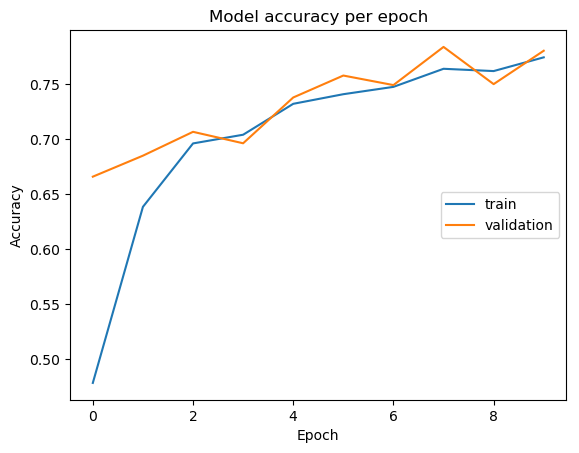

In [24]:
train_acc = model_history.history['acc'] 
val_acc = model_history.history['val_acc']

plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Model accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='right')


In [25]:
y_val_pred = model.predict(X_val_3)

38/38 [==============================] - 15s 390ms/step


In [26]:
pred_class_val = y_val_pred.argmax(axis=1)
true_class_val = y_val.argmax(axis=1)
print(classification_report(true_class_val, pred_class_val))


              precision    recall  f1-score   support

           0       0.69      0.80      0.74       371
           1       0.77      0.84      0.80       391
           2       0.92      0.72      0.81       438

    accuracy                           0.78      1200
   macro avg       0.79      0.79      0.78      1200
weighted avg       0.80      0.78      0.79      1200

